In [1]:
# !pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

In [16]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

## Loading the models

This code (and that in the next section) comes from the [Huggingface example notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

This will download and set up the relevant models and components we'll be using. Let's just run this for now and move on to the next section to check that it all works before diving deeper.

If you've loaded a pipeline, you can also access these components using `pipe.unet`, `pipe.vae` and so on.

In this notebook we aren't doing any memory-saving tricks - if you find yourself running out of GPU RAM, look at the pipeline code for inspiration with things like attention slicing, switching to half precision (fp16), keeping the VAE on the CPU and other modifications.

In [17]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

## The Autoencoder (AE)

The AE can 'encode' an image into some sort of latent representation, and decode this back into an image. I've wrapped the code for this into a couple of functions here so we can see what this looks like in action:

In [4]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

We'll use a pic from the web here, but you can load your own instead by uploading it and editing the filename in the next cell.

In [18]:
# Prep Scheduler
num_inference_steps = 30            # Number of denoising steps
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

set_timesteps(scheduler,num_inference_steps)

In [19]:
set_timesteps(scheduler, 15)

### Token embeddings

The token is fed to the `token_embedding` to transform it into a vector. The function name `get_input_embeddings` here is misleading since these token embeddings need to be combined with the position embeddings before they are actually used as inputs to the model! Anyway, let's look at just the token embedding part first

We can look at the embedding layer:

In [20]:
import torch
import torch.nn.functional as F
from transformers import CLIPModel, CLIPProcessor

# Globals used by blue_loss()
clip_model = None
clip_processor = None
clip_text_feat = None

def setup_clip_for_prompt(prompt: str, device):
    global clip_model, clip_processor, clip_text_feat

    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    clip_model.eval()
    for p in clip_model.parameters():
        p.requires_grad_(False)

    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # store prompt embedding once
    with torch.no_grad():
        text_inputs = clip_processor(text=[prompt], return_tensors="pt", padding=True, truncation=True).to(device)
        txt = clip_model.get_text_features(**text_inputs)
        clip_text_feat = F.normalize(txt, dim=-1)  # (1, D)


def blue_loss(images):
    """
    images: (B,3,H,W) in range [0,1]
    Returns a single scalar loss.
    """
    # ----------------------------
    # (A) CLIP semantic loss
    # ----------------------------
    # Differentiable preprocess for CLIP
    x = F.interpolate(images, size=(224, 224), mode="bilinear", align_corners=False)

    # CLIP normalization constants
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=x.device).view(1,3,1,1)
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=x.device).view(1,3,1,1)
    x = (x - mean) / std

    img_feat = clip_model.get_image_features(pixel_values=x)
    img_feat = F.normalize(img_feat, dim=-1)

    # 1 - cosine similarity (minimize => image matches prompt more)
    sim = (img_feat @ clip_text_feat.t()).squeeze(-1)  # (B,)
    L_clip = (1.0 - sim).mean()

    # ----------------------------
    # (B) Frequency balance loss (reduce blur)
    # ----------------------------
    # luminance
    y = (0.2989 * images[:,0] + 0.5870 * images[:,1] + 0.1140 * images[:,2])  # (B,H,W)

    Freq = torch.fft.fft2(y)
    mag = torch.abs(torch.fft.fftshift(Freq, dim=(-2, -1)))  # (B,H,W)

    B, H, W = mag.shape
    yy, xx = torch.meshgrid(
        torch.linspace(-0.5, 0.5, H, device=mag.device),
        torch.linspace(-0.5, 0.5, W, device=mag.device),
        indexing="ij"
    )
    rr = torch.sqrt(xx**2 + yy**2)

    split = 0.15  # center radius treated as "low frequency"
    low_mask  = (rr <= split).float()
    high_mask = (rr >  split).float()

    low_e  = (mag * low_mask).mean(dim=(-2, -1))
    high_e = (mag * high_mask).mean(dim=(-2, -1))
    ratio = high_e / (low_e + high_e + 1e-8)

    target_ratio = 0.35
    L_freq = (ratio - target_ratio).abs().mean()

    # ----------------------------
    # (C) Tiny composition loss (keep saliency near center)
    # ----------------------------
    # saliency via gradient magnitude on luminance
    y2 = y.unsqueeze(1)  # (B,1,H,W)
    gx = y2[..., :, 1:] - y2[..., :, :-1]
    gy = y2[..., 1:, :] - y2[..., :-1, :]
    gx = F.pad(gx, (0,1,0,0))
    gy = F.pad(gy, (0,0,0,1))
    sal = torch.sqrt(gx*gx + gy*gy + 1e-12).squeeze(1)  # (B,H,W)

    xs = torch.linspace(0, 1, W, device=sal.device).view(1,1,W).expand(B,H,W)
    ys = torch.linspace(0, 1, H, device=sal.device).view(1,H,1).expand(B,H,W)

    mass = sal.sum(dim=(-2, -1)) + 1e-8
    cx = (sal * xs).sum(dim=(-2, -1)) / mass
    cy = (sal * ys).sum(dim=(-2, -1)) / mass

    # target center (0.5,0.5)
    L_comp = ((cx - 0.5)**2 + (cy - 0.5)**2).mean()

    # ----------------------------
    # Combine (weights)
    # ----------------------------
    w_clip = 1.0
    w_freq = 0.15
    w_comp = 0.05

    return (w_clip * L_clip) + (w_freq * L_freq) + (w_comp * L_comp)


In [14]:




def generate_one(prompt, seed, blue_loss_scale=0):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 50  #@param           # Number of denoising steps
    guidance_scale = 8 #@param               # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1
    blue_loss_scale = 200 #@param

    setup_clip_for_prompt(prompt, torch_device)
    
    generator = torch.manual_seed(seed)
    # Prep text
    text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    # And the uncond. input as before:
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
      (batch_size, unet.in_channels, height // 8, width // 8),
      generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma
    printed_initial = False
    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        #### ADDITIONAL GUIDANCE ###
        # if i%5 == 0:
        if (i % 5 == 0) and (i > num_inference_steps * 0.2):
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            latents_x0 = latents - sigma * noise_pred
            # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)
            denoised_images = denoised_images.clamp(0, 1)
            # Calculate loss
            #loss = blue_loss(denoised_images) * blue_loss_scale
            loss = blue_loss(denoised_images.float()) * blue_loss_scale

           # Occasionally print it out
            if i%10==0:
                print(i, 'loss:', loss.item())

            # Get gradient
            #cond_grad = torch.autograd.grad(loss, latents)[0]
            cond_grad = torch.autograd.grad(loss, latents, retain_graph=False, create_graph=False)[0]

            # gradient clipping
            max_norm = 0.5
            g_norm = cond_grad.norm()
            cond_grad = cond_grad * (max_norm / (g_norm + 1e-8))

            # Modify the latents based on this gradient
            #latents = latents.detach() - cond_grad * sigma**2
            step_size = 0.05   # try 0.02, 0.05, 0.1
            latents = latents.detach() - step_size * cond_grad * sigma**2
        # Now step with scheduler
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # if not printed_initial:
    #     with torch.no_grad():
    #         latents_x0_init = latents
    #         init_img = vae.decode((1 / 0.18215) * latents_x0_init).sample / 2 + 0.5
    #         init_img = init_img.clamp(0, 1)

    #     print("Initial image (prompt-only, no custom loss):")
    #     display(latents_to_pil(latents_x0_init)[0])

    #     printed_initial = True


    return latents_to_pil(latents)[0]


Style: Oil painting (impasto) | Seed: 32


/var/folders/rl/nqn2hy9x6899jjgxlb9229rh0000gn/T/ipykernel_58322/378239091.py:32: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


20 loss: 159.91712951660156
30 loss: 160.5469207763672
40 loss: 160.8970947265625


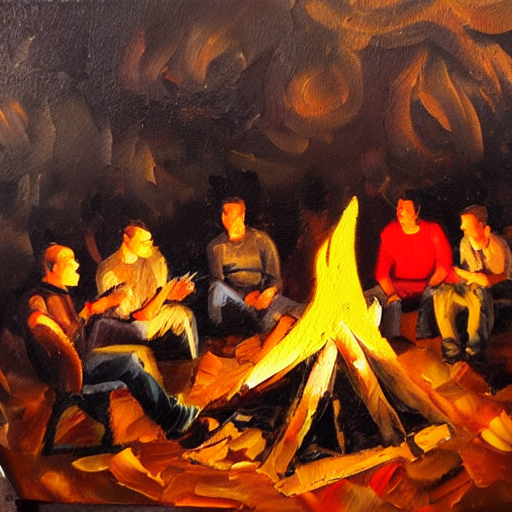


Style: Watercolor | Seed: 101


  0%|          | 0/50 [00:00<?, ?it/s]

20 loss: 162.9791259765625
30 loss: 165.0343475341797
40 loss: 165.4994659423828


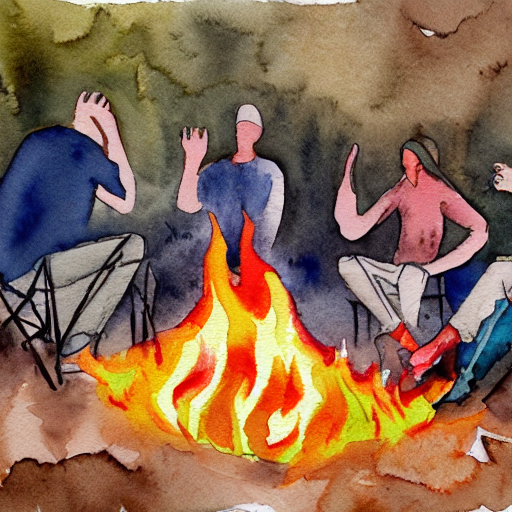


Style: Pencil sketch | Seed: 202


  0%|          | 0/50 [00:00<?, ?it/s]

20 loss: 159.72239685058594
30 loss: 159.7225799560547
40 loss: 159.55078125


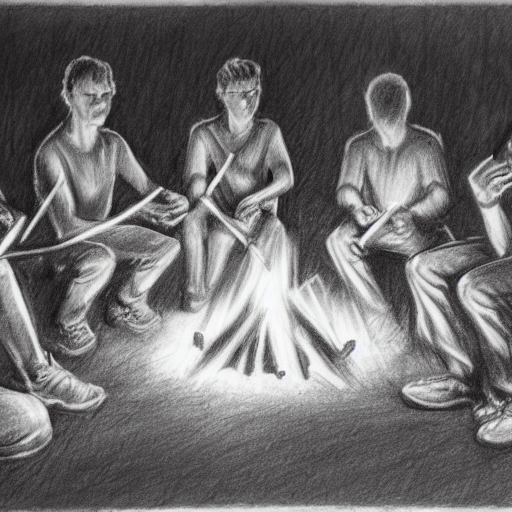


Style: Cyberpunk neon | Seed: 303


  0%|          | 0/50 [00:00<?, ?it/s]

20 loss: 157.46304321289062
30 loss: 157.45509338378906
40 loss: 157.9932098388672


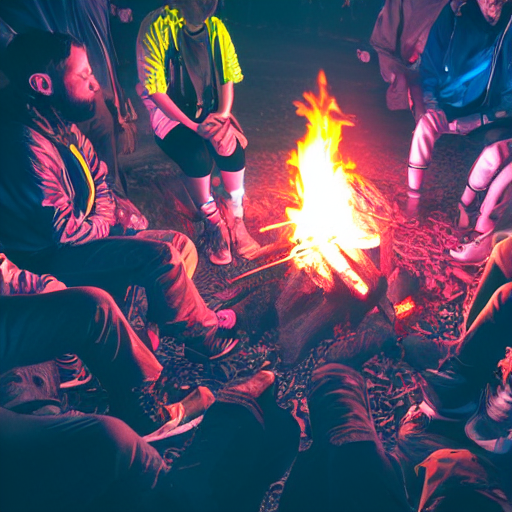


Style: Pixel art | Seed: 404


  0%|          | 0/50 [00:00<?, ?it/s]

20 loss: 154.23793029785156
30 loss: 154.78359985351562
40 loss: 155.5616912841797


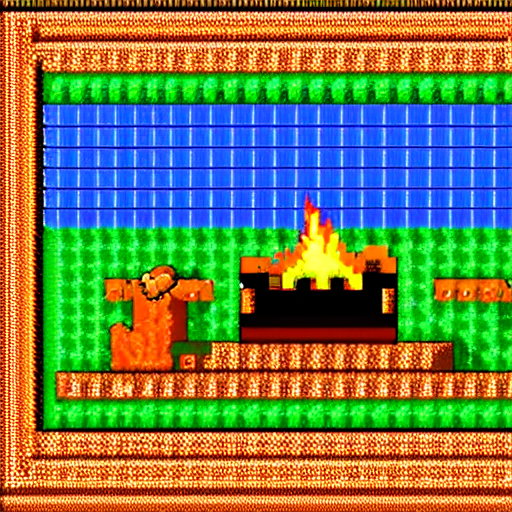

In [15]:
base_prompt = "A campfire with group of people"
styles = [
    ("Oil painting (impasto)", "oil painting, impasto, thick brush strokes, canvas texture"),
    ("Watercolor", "watercolor painting, soft wash, paper texture"),
    ("Pencil sketch", "pencil sketch, graphite, cross-hatching, monochrome"),
    ("Cyberpunk neon", "cyberpunk, neon lighting, futuristic, high contrast"),
    ("Pixel art", "pixel art, 16-bit, low resolution, retro game style"),
]

seeds = [32, 101, 202, 303, 404]

results = []

for (style_name, style_suffix), seed in zip(styles, seeds):
    prompt = f"{base_prompt}, {style_suffix}"
    print(f"\nStyle: {style_name} | Seed: {seed}")
    img = generate_one(prompt, seed, blue_loss_scale=0)  # prompt-only baseline
    display(img)
    results.append({"style": style_name, "seed": seed, "prompt": prompt, "image": img})